<a href="https://colab.research.google.com/github/sexymonster/Reinforcement-Learning/blob/main/deeprl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow-gpu==2.0.0.alpha0
!pip install tensorflow-gpu==2.0.0

!pip install pandas-datareader==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader

from tqdm import tqdm_notebook, tqdm
from collections import deque

In [ ]:
data_reader.__version__

'0.10.0'

In [ ]:
class AI_Trader():
  
  def __init__(self, state_size, action_space=3, model_name="AITrader"):
    
    self.state_size = state_size
    self.action_space = action_space
    self.memory = deque(maxlen = 2000)
    self.inventory = []
    self.model = self.model_builder()
    self.model_name = self.model.name
    
    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.995
  
  def model_builder(self):
      
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))
    model.compile(loss='mse', optimizer="Adam",lr=0.001)
    return model

  def trade(self, state):
    if random.random() <= self.epsilon:
      return random.randrange(self.action_space)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])
    
  def batch_train(self, batch_size):

    batch = []
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
      batch.append(self.memory[i])

    for state, action, reward, next_state, done in batch:
      target = self.model.predict(state)

      if not done:
        target[0][action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

      target[0][action] = reward

      self.model.fit(state, target, epochs=1, verbose=0)

    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay

In [ ]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [ ]:
def stocks_price_format(n):
  if n < 0:
    return "- # {0:2f}".format(abs(n))
  else:
    return "$ {0:2f}".format(abs(n))

In [ ]:
def dataset_loader(stock_name):

  dataset = data_reader.DataReader(stock_name, data_source="yahoo")
  
  start_date = str(dataset.index[0]).split()[0]
  end_date = str(dataset.index[1]).split()[0]
  
  close = dataset['Close']
  
  return close

In [ ]:
# def state_creator(data, timestep, window_size):
  
#   starting_id = timestep - window_size + 1
#   print(starting_id)
#   if starting_id >= 0:
#     windowed_data = data[starting_id:timestep+1]
#   else:
#     windowed_data = starting_id * [data[0]] + list(data[0:timestep+1])
#   print(windowed_data)
#   state = []
#   for i in range(window_size - 1):
#     print(i)
#     state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))
    
#   return np.array([state])

In [ ]:
def state_creator(data, timestep, window_size):
  
  starting_id = timestep - window_size + 1
  if starting_id >= 0:
    windowed_data = data[starting_id:timestep+1]
  else:
    windowed_data = starting_id * [data[0]] + list(data[0:timestep+1])
  state = []
  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))
    
  return np.array([state])

In [ ]:
dataset = data_reader.DataReader("AAPL",data_source = "yahoo",start="2022-08-01")
# dataset = data_reader.get_data_yahoo("005930.KS",start="2020-01-01",end="2021-01-01")
# dataset = data_reader.DataReader("AAPL", "yahoo",start="2020-01-01",end="2021-01-01")

In [ ]:
dataset

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-01,163.589996,160.889999,161.009995,161.509995,67829400.0,161.018845
2022-08-02,162.410004,159.630005,160.100006,160.009995,59907000.0,159.523407
2022-08-03,166.589996,160.750000,160.839996,166.130005,82507500.0,165.624817
2022-08-04,167.190002,164.429993,166.009995,165.809998,55474100.0,165.305786
2022-08-05,165.850006,163.000000,163.210007,165.350006,56697000.0,165.076172
...,...,...,...,...,...,...
2022-11-02,152.169998,145.000000,148.949997,145.029999,93604600.0,144.789810
2022-11-03,142.800003,138.750000,142.059998,138.880005,97918500.0,138.650009
2022-11-04,142.669998,134.380005,142.089996,138.380005,140716700.0,138.380005


In [ ]:
stock_name = "AAPL"
data = dataset_loader(stock_name)

In [ ]:
data = data["2022-06-01":]
data

Date
2022-06-01    148.710007
2022-06-02    151.210007
2022-06-03    145.380005
2022-06-06    146.139999
2022-06-07    148.710007
                 ...    
2022-11-02    145.029999
2022-11-03    138.880005
2022-11-04    138.380005
2022-11-07    138.919998
2022-11-08    139.500000
Name: Close, Length: 112, dtype: float64

In [ ]:
window_size = 10
episodes = 1

batch_size = 32
data_samples = len(data) - 1

In [ ]:
trader = AI_Trader(window_size)
trader.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 387       
Total params: 11,171
Trainable params: 11,171
Non-trainable params: 0
_________________________________________________________________


In [ ]:
state_creator(data, 10, window_size + 1)

array([[0.92414182, 0.00292946, 0.68135254, 0.92890618, 0.3208213 ,
        0.0048689 , 0.00402982, 0.00522013, 0.70682007, 0.93523292]])

In [ ]:
for episode in range(1, episodes + 1):
  
  print("Episode: {}/{}".format(episode, episodes))
  
  state = state_creator(data, 10, window_size + 1)

  action = [0]
  total_profit = 0
  trader.inventory = []
  
  # for t in tqdm(range(data_samples)):
  for t in tqdm(range(window_size,data_samples)):
  
    action = trader.trade(state)
    
    next_state = state_creator(data, t+1, window_size + 1)
    reward = 0
    
    if action == 1: #Buying
      trader.inventory.append(data[t])
      print("AI Trader bought: ", stocks_price_format(data[t]))
      
    elif action == 2 and len(trader.inventory) > 0: #Selling
      buy_price = trader.inventory.pop(0)
      
      reward = max(data[t] - buy_price, 0)
      total_profit += data[t] - buy_price
      print("AI Trader sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price) )
      
    if t == data_samples - 1:
      done = True
    else:
      done = False
      
    trader.memory.append((state, action, reward, next_state, done))
    
    state = next_state
    
    if done:
      print("########################")
      print("TOTAL PROFIT: {}".format(total_profit))
      print("########################")
    
    if len(trader.memory) > batch_size:
      trader.batch_train(batch_size)
      
  if episode % 10 == 0:
    trader.model.save("ai_trader_{}.h5".format(episode))

Episode: 1/1


  0%|          | 0/101 [00:00<?, ?it/s]

AI Trader bought:  $ 135.429993
AI Trader bought:  $ 130.059998
AI Trader bought:  $ 135.869995
AI Trader sold:  $ 135.350006  Profit: - # 0.079987
AI Trader bought:  $ 138.270004
AI Trader sold:  $ 141.660004  Profit: $ 11.600006
AI Trader bought:  $ 137.440002
AI Trader bought:  $ 139.229996
AI Trader sold:  $ 136.720001  Profit: $ 0.850006
AI Trader sold:  $ 138.929993  Profit: $ 0.659988
AI Trader sold:  $ 141.559998  Profit: $ 4.119995
AI Trader bought:  $ 142.919998
AI Trader sold:  $ 147.039993  Profit: $ 7.809998
AI Trader sold:  $ 144.869995  Profit: $ 1.949997
AI Trader bought:  $ 145.860001
AI Trader bought:  $ 148.470001
AI Trader bought:  $ 150.169998
AI Trader bought:  $ 155.350006
AI Trader sold:  $ 152.949997  Profit: $ 7.089996
AI Trader sold:  $ 156.789993  Profit: $ 8.319992
AI Trader sold:  $ 161.509995  Profit: $ 11.339996
AI Trader sold:  $ 160.009995  Profit: $ 4.659988


 33%|███▎      | 33/101 [00:02<00:05, 11.47it/s]

AI Trader bought:  $ 166.130005
AI Trader sold:  $ 165.809998  Profit: - # 0.320007


 38%|███▊      | 38/101 [00:21<01:11,  1.14s/it]

AI Trader bought:  $ 169.240005


 39%|███▊      | 39/101 [00:23<01:20,  1.30s/it]

AI Trader bought:  $ 168.490005


 40%|███▉      | 40/101 [00:26<01:30,  1.48s/it]

AI Trader bought:  $ 172.100006


 42%|████▏     | 42/101 [00:31<01:47,  1.83s/it]

AI Trader sold:  $ 173.029999  Profit: $ 3.789993


 43%|████▎     | 43/101 [00:33<01:55,  1.99s/it]

AI Trader bought:  $ 174.550003


 44%|████▎     | 44/101 [00:36<02:00,  2.12s/it]

AI Trader sold:  $ 174.149994  Profit: $ 5.659988


 45%|████▍     | 45/101 [00:39<02:07,  2.28s/it]

AI Trader bought:  $ 171.520004


 47%|████▋     | 47/101 [00:57<04:42,  5.22s/it]

AI Trader sold:  $ 167.229996  Profit: - # 4.870010


 48%|████▊     | 48/101 [00:59<03:59,  4.52s/it]

AI Trader sold:  $ 167.529999  Profit: - # 7.020004


 50%|████▉     | 50/101 [01:04<03:00,  3.54s/it]

AI Trader bought:  $ 163.619995


 50%|█████     | 51/101 [01:07<02:41,  3.23s/it]

AI Trader sold:  $ 161.380005  Profit: - # 10.139999


 54%|█████▍    | 55/101 [01:17<02:03,  2.69s/it]

AI Trader bought:  $ 155.809998


 56%|█████▋    | 57/101 [01:22<01:55,  2.63s/it]

AI Trader sold:  $ 155.960007  Profit: - # 7.659988


 57%|█████▋    | 58/101 [01:25<01:51,  2.59s/it]

AI Trader sold:  $ 154.460007  Profit: - # 1.349991


 59%|█████▉    | 60/101 [01:30<01:45,  2.57s/it]

AI Trader bought:  $ 163.429993


 61%|██████▏   | 62/101 [01:35<01:39,  2.54s/it]

AI Trader bought:  $ 155.309998


 62%|██████▏   | 63/101 [01:37<01:36,  2.54s/it]

AI Trader sold:  $ 152.369995  Profit: - # 11.059998


 63%|██████▎   | 64/101 [01:40<01:40,  2.71s/it]

AI Trader sold:  $ 150.699997  Profit: - # 4.610001


 70%|███████   | 71/101 [02:05<01:31,  3.06s/it]

AI Trader bought:  $ 151.759995


 71%|███████▏  | 72/101 [02:08<01:23,  2.89s/it]

AI Trader bought:  $ 149.839996


 72%|███████▏  | 73/101 [02:10<01:17,  2.78s/it]

AI Trader sold:  $ 142.479996  Profit: - # 9.279999


 73%|███████▎  | 74/101 [02:13<01:12,  2.69s/it]

AI Trader bought:  $ 138.199997


 76%|███████▌  | 77/101 [02:20<01:02,  2.60s/it]

AI Trader bought:  $ 146.399994


 77%|███████▋  | 78/101 [02:23<00:59,  2.59s/it]

AI Trader bought:  $ 145.429993


 78%|███████▊  | 79/101 [02:25<00:56,  2.58s/it]

AI Trader sold:  $ 140.089996  Profit: - # 9.750000


 79%|███████▉  | 80/101 [02:28<00:53,  2.56s/it]

AI Trader sold:  $ 140.419998  Profit: $ 2.220001


 80%|████████  | 81/101 [02:30<00:51,  2.55s/it]

AI Trader bought:  $ 138.979996


 81%|████████  | 82/101 [02:33<00:49,  2.59s/it]

AI Trader sold:  $ 138.339996  Profit: - # 8.059998


 82%|████████▏ | 83/101 [02:37<00:52,  2.89s/it]

AI Trader sold:  $ 142.990005  Profit: - # 2.439987


 84%|████████▍ | 85/101 [02:43<00:49,  3.10s/it]

AI Trader bought:  $ 142.410004


 86%|████████▌ | 87/101 [02:48<00:39,  2.80s/it]

AI Trader bought:  $ 143.860001


 87%|████████▋ | 88/101 [02:51<00:35,  2.72s/it]

AI Trader bought:  $ 143.389999


 88%|████████▊ | 89/101 [02:53<00:32,  2.67s/it]

AI Trader bought:  $ 147.270004


 90%|█████████ | 91/101 [03:05<00:39,  3.91s/it]

AI Trader sold:  $ 152.339996  Profit: $ 13.360001


 92%|█████████▏| 93/101 [03:10<00:25,  3.17s/it]

AI Trader bought:  $ 144.800003


 93%|█████████▎| 94/101 [03:12<00:20,  2.97s/it]

AI Trader sold:  $ 155.740005  Profit: $ 13.330002


 94%|█████████▍| 95/101 [03:14<00:16,  2.81s/it]

AI Trader bought:  $ 153.339996


 95%|█████████▌| 96/101 [03:17<00:13,  2.72s/it]

AI Trader sold:  $ 150.649994  Profit: $ 6.789993


 98%|█████████▊| 99/101 [03:25<00:05,  2.62s/it]

AI Trader bought:  $ 138.380005


 99%|█████████▉| 100/101 [03:27<00:02,  2.60s/it]

AI Trader sold:  $ 138.919998  Profit: - # 4.470001
########################
TOTAL PROFIT: 22.439971923828125
########################


100%|██████████| 101/101 [03:30<00:00,  2.08s/it]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: ignored

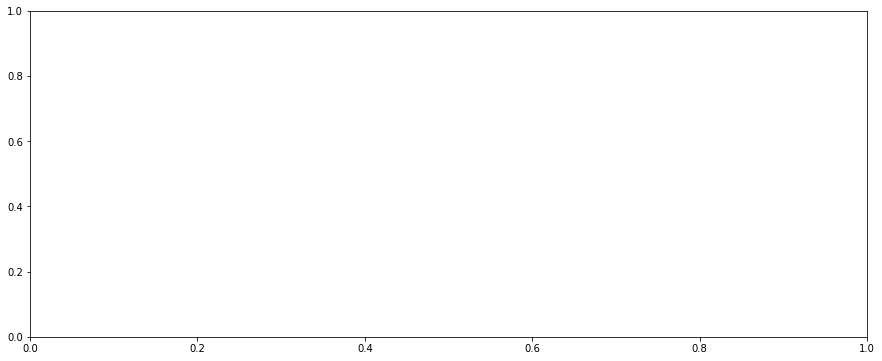

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
plt.plot(trader.memory)
plt.show()

In [ ]:
trader.memory[0]

(array([[0.92414182, 0.00292946, 0.68135254, 0.92890618, 0.3208213 ,
         0.0048689 , 0.00402982, 0.00522013, 0.70682007, 0.93523292]]),
 1,
 0,
 array([[0.00292946, 0.68135254, 0.92890618, 0.3208213 , 0.0048689 ,
         0.00402982, 0.00522013, 0.70682007, 0.93523292, 0.00463259]]),
 False)